In [24]:
import csv
import numpy as np

filename = 'merged_file_4d.csv'
data = np.loadtxt(filename, delimiter=',', skiprows=1)
ids = np.unique(data[:, 1])  # 물체 id 목록

features = []
labels = []

# 물체별 가속도 계산
for id in ids:
    idx = np.where(data[:, 1] == id)[0]
    t = data[idx, 0]
    x = data[idx, 2]
    y = data[idx, 3]

    if id < 100:
        dt = t[1] - t[0]
        vx = np.diff(x) / dt  # x 방향 속도
        vy = np.diff(y) / dt  # y 방향 속도
        ax = np.diff(vx) / dt  # x 방향 가속도
        ay = np.diff(vy) / dt  # y 방향 가속도
        avg_ax = round(np.mean(ax),2)  # x 방향 평균 가속도
        avg_ay = round(np.mean(ay),2)  # y 방향 평균 가속도

     
        if avg_ax == 0 and avg_ay == 0:
            label = 0  # 직선 운동
        elif avg_ax == 0 and avg_ay < 0:
            label = 1  # 포물선 운동
        else:
            label = 2  # 바운싱 운동

        features.append([avg_ax, avg_ay])
        labels.append(label)

    if id >= 100:
        vx = np.diff(x) / np.diff(t)  # x 방향 가속도
        vy = np.diff(y) / np.diff(t)  # y 방향 가속도
        avg_ax = round(np.mean(vx),2)  # x 방향 평균 가속도
        avg_ay = round(np.mean(vy),2)  # y 방향 평균 가속도

      
        if avg_ax == 0 and avg_ay == 0:
            label = 0  # 직선 운동
        elif avg_ax == 0 and avg_ay < 0:
            label = 1  # 포물선 운동
        else:
            label = 2  # 바운싱 운동

    
        features.append([avg_ax, avg_ay])
        labels.append(label)
print(features)
print(labels)

[[-0.0, -0.0], [0.0, 0.0], [-0.0, -0.0], [-0.0, -0.0], [0.0, 0.0], [-0.0, 0.0], [-0.0, -0.0], [-0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-0.0, -0.0], [0.0, 0.0], [0.0, 0.0], [-0.0, -0.0], [-0.0, 0.0], [0.0, -0.0], [0.0, -0.0], [-0.0, -0.0], [0.0, -0.0], [0.0, -0.0], [-0.0, -0.0], [-0.0, -0.0], [-0.0, 0.0], [-0.0, 0.0], [-0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-0.0, 0.0], [-0.0, 0.0], [-0.0, -0.0], [-0.0, 0.0], [-0.0, 0.0], [0.0, 0.0], [-0.0, -0.0], [0.0, 0.0], [-0.0, -0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, -0.0], [-0.0, -0.0], [-0.0, 0.0], [-0.0, -0.0], [-0.0, -0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [-0.0, -0.0], [0.0, 0.0], [0.0, -999.5], [0.0, -999.5], [-0.0, -999.5], [0.0, -999.5], [-0.0, -999.5], [-0.0, -999.5], [-0.0, -999.5], [0.0, -999.5], [0.0, -999.5], [-0.0, -999.5], [0.0, -999.5], [0.0, -999.5], [-0.0, -999.5], [-0.0, -999.5], [-0.0, -999.5], [-0.0, -999.5], [0.0, -999.5], [-0.0, -999.5], [0.0, -999.5], [0.0, -999.5], [0.0, -999.5], [-0.0, -999.5], [0.0, -999

## train test data split

In [25]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

## data normalization

In [26]:
from sklearn.preprocessing import StandardScaler


normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')

Train set dimension is (140, 2)
Test set dimension is (60, 2)


## Find best parameter

In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

svc = SVC(random_state=2021)
param_grid = [{'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
              {'kernel': ['poly'], 'degree':[2, 3, 5],'C': [0.1, 1, 10, 100, 1000]},
              {'kernel': ['rbf'], 'gamma': ['auto', 'scale'],'C': [0.1, 1, 10, 100, 1000]},
              {'kernel': ['sigmoid'], 'gamma': ['auto', 'scale'],'C': [0.1, 1, 10, 100, 1000]}]

scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, scoring = f'{score}_macro', cv=10, verbose=1 ,n_jobs=12)
    CV_svc.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(CV_svc.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = CV_svc.cv_results_['mean_test_score']
    stds = CV_svc.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, CV_svc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, CV_svc.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=12)
CV_svc.fit(X_train, y_train)

# Tuning hyper-parameters for precision

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/Users/sim-yeji/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sim-yeji/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sim-yeji/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sim-yeji/opt/anaconda3/lib/python3.9/site-

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.957 (+/-0.111) for {'C': 0.1, 'kernel': 'linear'}
0.968 (+/-0.104) for {'C': 1, 'kernel': 'linear'}
0.993 (+/-0.040) for {'C': 10, 'kernel': 'linear'}
0.993 (+/-0.040) for {'C': 100, 'kernel': 'linear'}
0.993 (+/-0.040) for {'C': 1000, 'kernel': 'linear'}
0.987 (+/-0.053) for {'C': 0.1, 'degree': 2, 'kernel': 'poly'}
0.902 (+/-0.359) for {'C': 0.1, 'degree': 3, 'kernel': 'poly'}
0.548 (+/-0.018) for {'C': 0.1, 'degree': 5, 'kernel': 'poly'}
0.967 (+/-0.102) for {'C': 1, 'degree': 2, 'kernel': 'poly'}
0.982 (+/-0.074) for {'C': 1, 'degree': 3, 'kernel': 'poly'}
0.978 (+/-0.089) for {'C': 1, 'degree': 5, 'kernel': 'poly'}
0.993 (+/-0.040) for {'C': 10, 'degree': 2, 'kernel': 'poly'}
0.993 (+/-0.040) for {'C': 10, 'degree': 3, 'kernel': 'poly'}
0.993 (+/-0.040) for {'C': 10, 'degree': 5, 'kernel': 'poly'}
0.993 (+/-0.040) for {'C': 100, 'degree': 2, 'kernel': 'poly'}
0.993 (+/-

GridSearchCV(cv=10, estimator=SVC(random_state=2021), n_jobs=12,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 5],
                          'kernel': ['poly']},
                         {'C': [0.1, 1, 10, 100, 1000],
                          'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100, 1000],
                          'gamma': ['auto', 'scale'], 'kernel': ['sigmoid']}],
             verbose=1)

In [28]:
best_svc = CV_svc.best_estimator_
best_svc.fit(X_train, y_train)

SVC(C=10, kernel='linear', random_state=2021)

## SVM Model fit, score

In [29]:
# Train set에 대한 성능
y_pred = best_svc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = best_svc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}") 

Train set에 대한 성능
정확도:0.9929


Test set에 대한 성능
정확도:1.0000


In [30]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro')


print(f"정확도:{acc:0.4f}",f"민감도:{recall:0.4f}",f"정밀도:{precision:0.4f}", sep='  |  ') 

정확도:1.0000  |  민감도:1.0000  |  정밀도:1.0000


/Users/sim-yeji/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


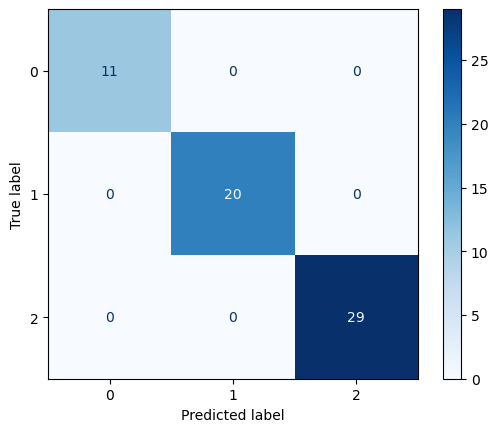

In [31]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(best_svc, X_test, y_test, cmap=plt.cm.Blues)
plt.show() 